<a href="https://colab.research.google.com/github/gsj1002/Portfolio_Website/blob/main/Movie_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# New Section

In [6]:
df = pd.read_csv("/content/IMDb Movies India.csv", encoding='ISO-8859-1')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


# Data processing

In [7]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [8]:
dataoveriew(df, 'Overiew of the training dataset')

Overiew of the training dataset:

Rows: 15509

Number of features: 10

Features:
['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

Missing values: 33523

Unique values:
Name        13838
Year          102
Duration      182
Genre         485
Rating         84
Votes        2034
Director     5938
Actor 1      4718
Actor 2      4891
Actor 3      4820
dtype: int64


In [9]:
df.isna().sum()

,0
Name,0
Year,528
Duration,8269
Genre,1877
Rating,7590
Votes,7589
Director,525
Actor 1,1617
Actor 2,2384
Actor 3,3144


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [11]:
df['Genre'].value_counts()

,count
Genre,
Drama,2780
Action,1289
Thriller,779
Romance,708
"Drama, Romance",524
...,...
"Action, Musical, War",1
"Horror, Crime, Thriller",1
"Animation, Comedy",1


In [12]:
df['Director'].value_counts()

,count
Director,
Jayant Desai,58
Kanti Shah,57
Babubhai Mistry,50
Mahesh Bhatt,48
Master Bhagwan,47
...,...
Naeem Siddiqui,1
Shadaab Khan,1
Mystelle Brabbee,1


In [13]:
df['Actor 1'].value_counts()

,count
Actor 1,
Ashok Kumar,158
Dharmendra,140
Jeetendra,140
Mithun Chakraborty,133
Amitabh Bachchan,129
...,...
Vatsal Sheth,1
Ujala Baboria,1
Dimple Sewak,1


In [14]:
df['Actor 2'].value_counts()

,count
Actor 2,
Rekha,83
Hema Malini,72
Mithun Chakraborty,63
Dharmendra,61
Mala Sinha,48
...,...
Paris Keswani,1
Shubhangi Latkar,1
Amit Ghosh,1


In [15]:
df.head(10)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
5,...Aur Pyaar Ho Gaya,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
7,.in for Motion,(2008),59 min,Documentary,NaN,NaN,Anirban Datta,NaN,NaN,NaN
8,?: A Question Mark,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
9,@Andheri,(2014),116 min,"Action, Crime, Thriller",4.0,11,Biju Bhaskar Nair,Augustine,Fathima Babu,Byon


In [16]:
# As we are going to predict movie ratings based on features, we need to remove null values from features that can directly influence the results.
df.dropna(subset=['Name','Year','Duration','Votes','Rating'],inplace=True)
df.isna().sum()

,0
Name,0
Year,0
Duration,0
Genre,31
Rating,0
Votes,0
Director,1
Actor 1,75
Actor 2,117
Actor 3,163


In [17]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [18]:
dataoveriew(df, 'Overiew of the training dataset')

Overiew of the training dataset:

Rows: 5851

Number of features: 10

Features:
['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

Missing values: 387

Unique values:
Name        5570
Year          91
Duration     178
Genre        393
Rating        83
Votes       2030
Director    2549
Actor 1     2046
Actor 2     2373
Actor 3     2572
dtype: int64


In [19]:
# Remove parentheses from 'Year' column and convert to integer
df['Year'] = df['Year'].str.strip('()').astype(int)
# Remove commas from 'Votes' column and convert to integer
df['Votes'] = df['Votes'].str.replace(',', '').astype(int)
# Remove min from 'Duration' column andDurationonvert to integer
df['Duration'] = df['Duration'].str.replace('min', '').astype(int)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5851 entries, 1 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5851 non-null   object 
 1   Year      5851 non-null   int64  
 2   Duration  5851 non-null   int64  
 3   Genre     5820 non-null   object 
 4   Rating    5851 non-null   float64
 5   Votes     5851 non-null   int64  
 6   Director  5850 non-null   object 
 7   Actor 1   5776 non-null   object 
 8   Actor 2   5734 non-null   object 
 9   Actor 3   5688 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 502.8+ KB


In [21]:
df.describe()

,Year,Duration,Rating,Votes
count,5851.000000,5851.000000,5851.000000,5851.000000
mean,1996.416852,132.294480,5.931875,2611.273116
std,19.914640,26.555826,1.389942,13433.828528
min,1931.000000,21.000000,1.100000,5.000000
25%,1983.000000,117.000000,5.000000,28.000000
50%,2002.000000,134.000000,6.100000,119.000000
75%,2013.000000,150.000000,7.000000,862.500000
max,2021.000000,321.000000,10.000000,591417.000000


In [22]:
df.drop('Genre',axis=1,inplace=True)

In [23]:
df.head()

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142,7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82,5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


# Exploratory Data Analysis

<ipython-input-24-88af457ccfbe>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Year'],color='g')
<ipython-input-24-88af457ccfbe>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Rating'],color='g')


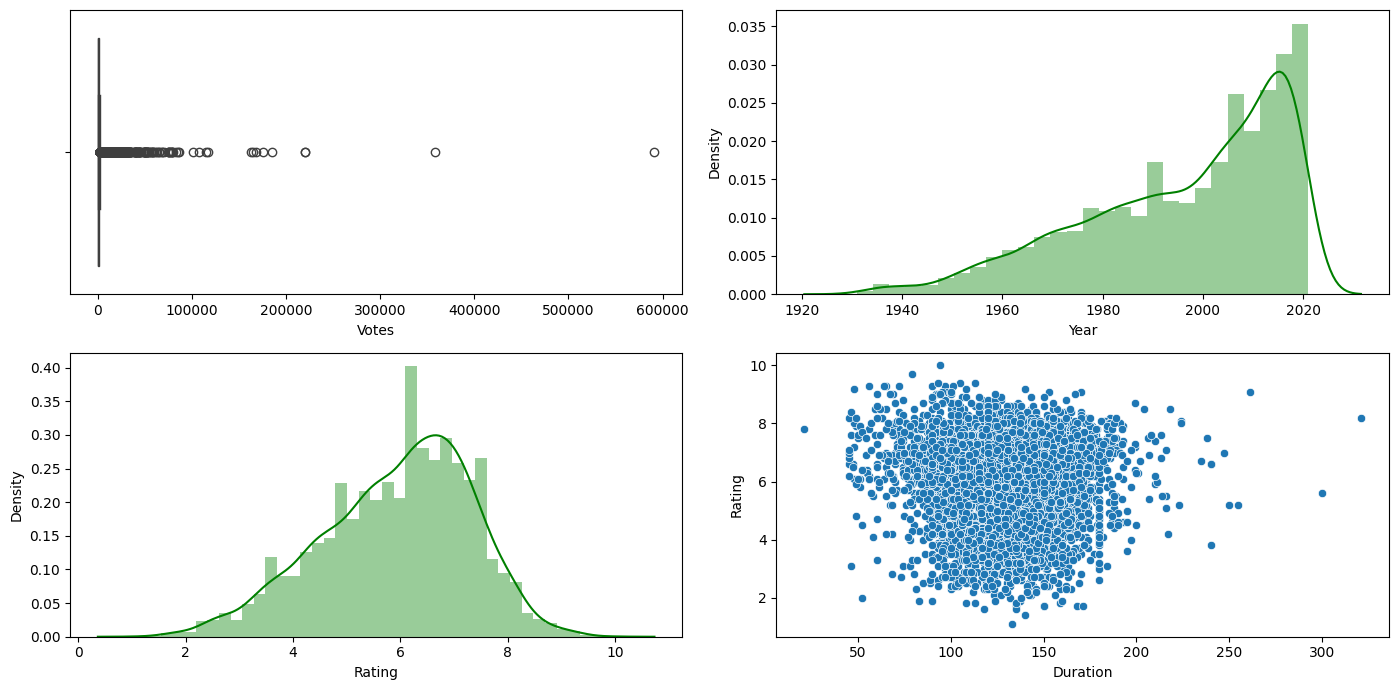

In [24]:
plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
sns.boxplot(x='Votes',data=df)

plt.subplot(2,2,2)
sns.distplot(df['Year'],color='g')

plt.subplot(2,2,3)
sns.distplot(df['Rating'],color='g')

plt.subplot(2,2,4)
sns.scatterplot(x=df['Duration'], y=df['Rating'], data=df)

plt.tight_layout()
plt.show()

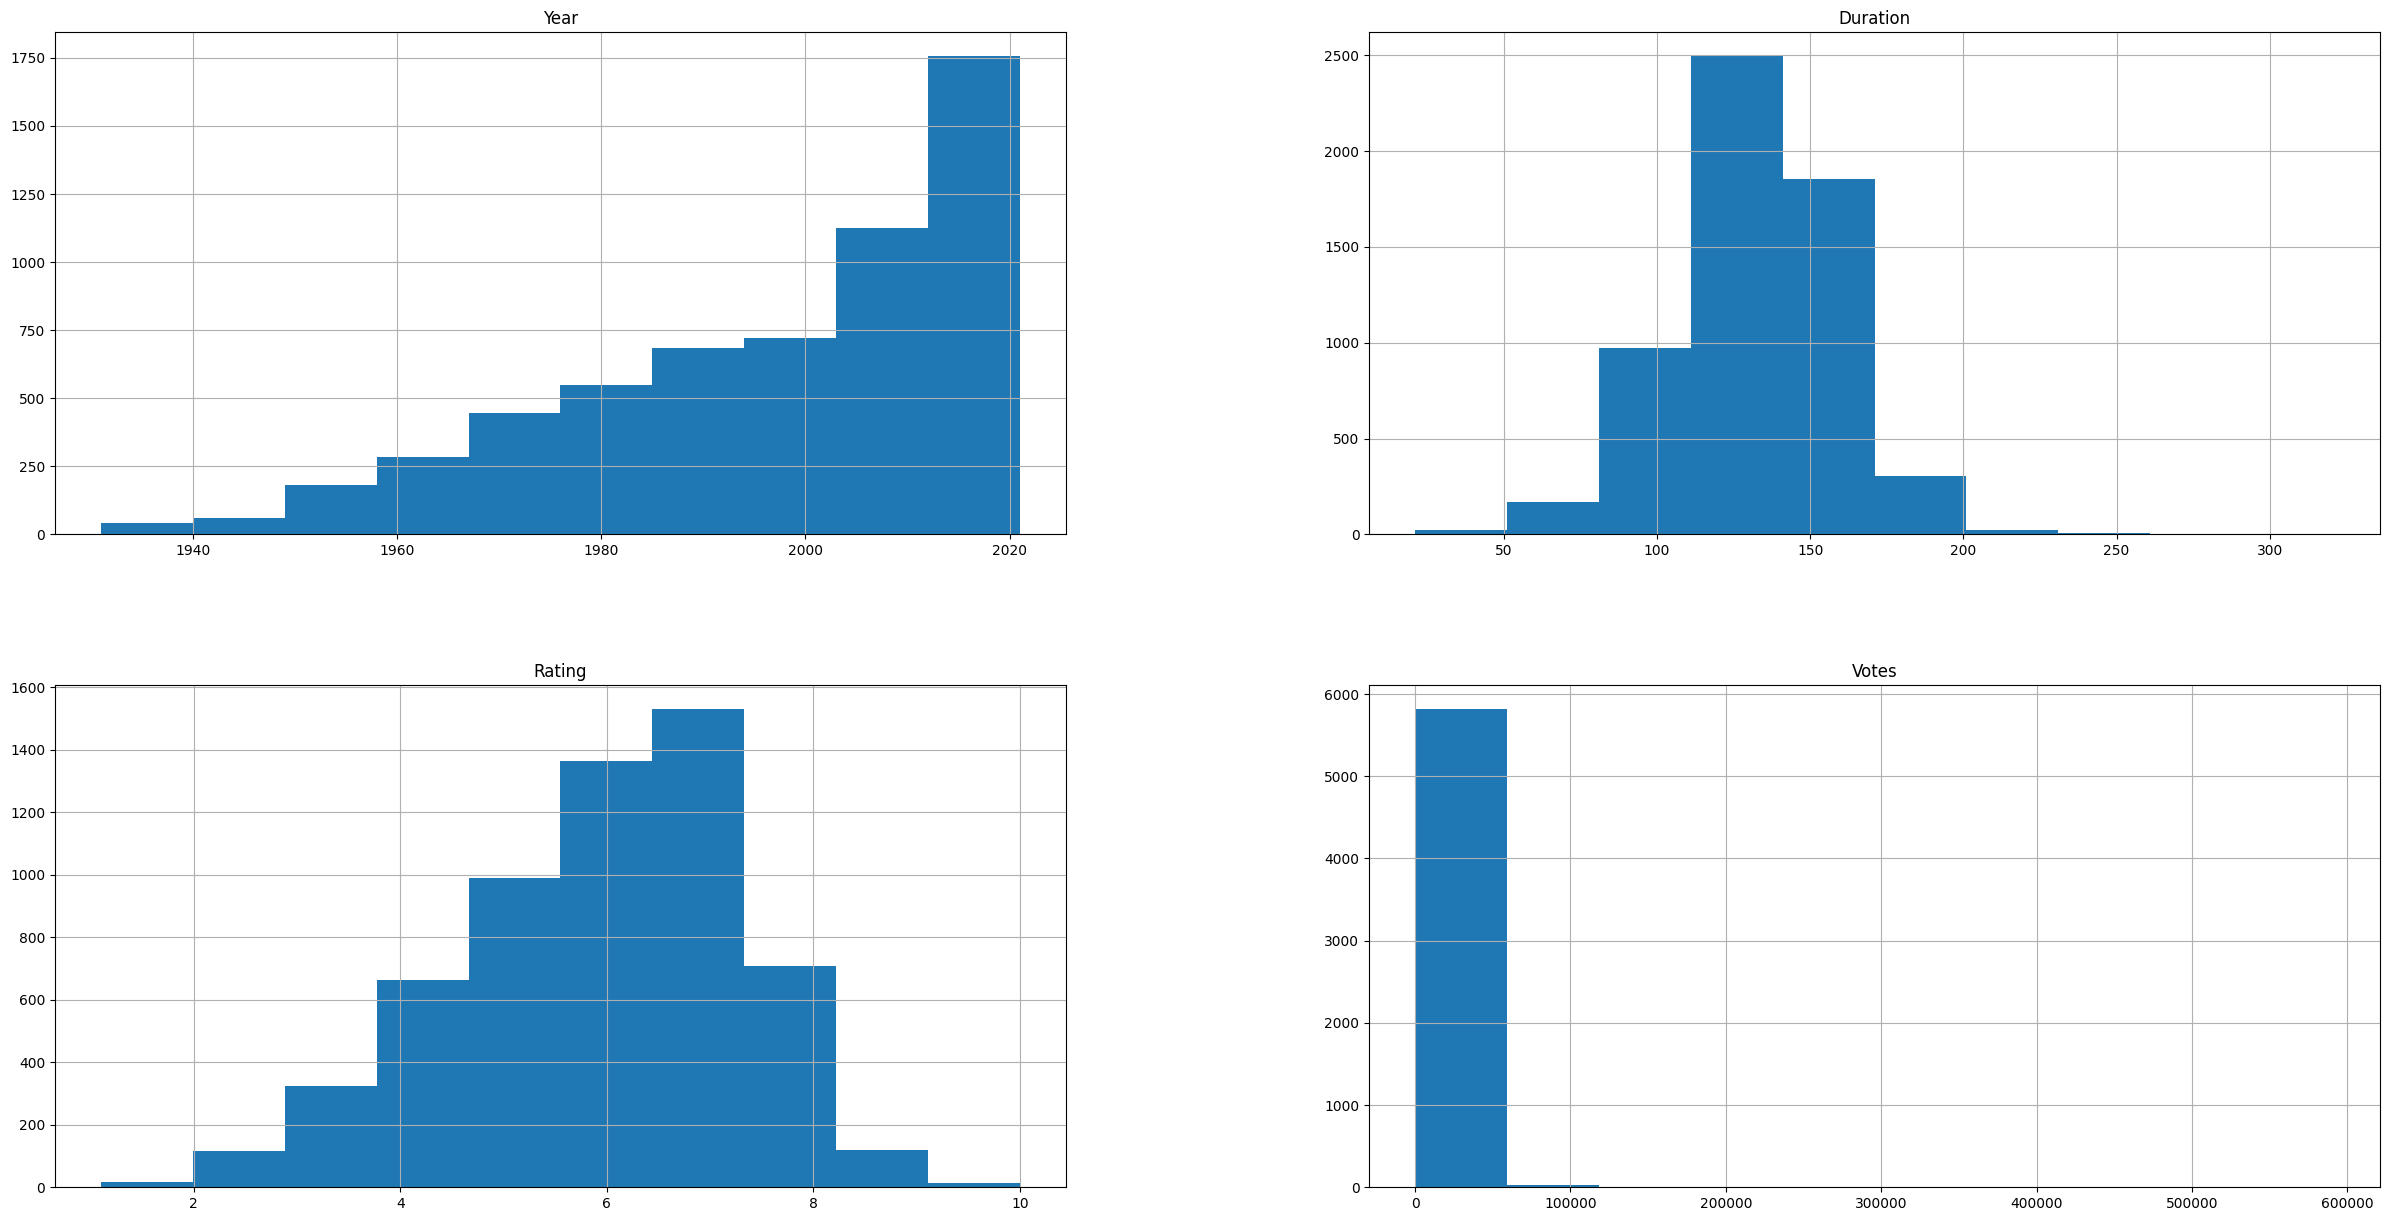

In [25]:
df.hist(figsize=(30, 15))
None

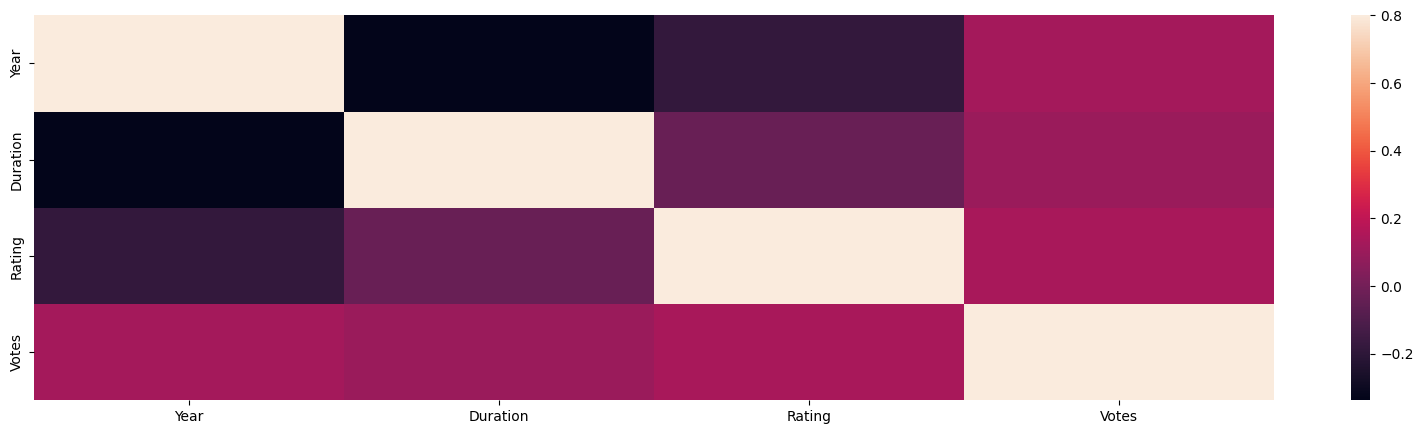

In [38]:
# Heatmap
corrmat = df.corr()
fig = plt.figure(figsize = (20, 5))

sns.heatmap(corrmat, vmax = .8, square = False, annot = False)
plt.show()

In [28]:
df.head()

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147,4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142,7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82,5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


# Feature Engineering

In [29]:
df.drop(['Name','Director','Actor 1','Actor 2','Actor 3'], axis=1,inplace=True)
df.head()

,Year,Duration,Rating,Votes
1,2019,109,7.0,8
3,2019,110,4.4,35
5,1997,147,4.7,827
6,2005,142,7.4,1086
8,2012,82,5.6,326


In [30]:
X = df[['Year','Duration','Votes']]
y = df['Rating']

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1000)

# Model Buiding

In [32]:
# Create a pipeline with standard scaling and SGD regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDRegressor(max_iter=10000, random_state=1000))
])

In [33]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDRegressor(max_iter=10000, random_state=1000))])

In [34]:
# Predict ratings on the test set
y_pred_pipeline = pipeline.predict(X_test)

# Model Evaluation

In [35]:
# Evaluation Metrics for the Pipeline
mae_pipeline = mean_absolute_error(y_test, y_pred_pipeline)
mse_pipeline = mean_squared_error(y_test, y_pred_pipeline)
r2_pipeline = r2_score(y_test, y_pred_pipeline)

In [36]:
print("Pipeline Mean Absolute Error:", mae_pipeline)
print("Pipeline Mean Squared Error:", mse_pipeline)
print("Pipeline R-squared:", r2_pipeline)

Pipeline Mean Absolute Error: 1.040142363499226
Pipeline Mean Squared Error: 1.75589466147756
Pipeline R-squared: 0.037929023872087186


# Model Deployment

In [37]:
# Take new user input for prediction
new_input = pd.DataFrame({
    'Year': [2023],          # Replace with the desired year
    'Duration': [120],       # Replace with the desired duration in minutes
    'Votes': [10000],        # Replace with the desired number of votes
})

# Use the trained pipeline to make predictions on the input
predicted_rating = pipeline.predict(new_input)

print("Predicted Rating:", predicted_rating)

Predicted Rating: [5.69062882]
